In [5]:
# get Data ()
import pandas as pd

# change csv for each 
persona_data = pd.read_csv("Results/TheBloke_Upstage-Llama-2-70B-instruct-v2-AWQ_persona_run.csv")
raw_data = pd.read_csv("Results/TheBloke_Upstage-Llama-2-70B-instruct-v2-AWQ_raw_run.csv")


In [6]:
#merge both datas to one
merged_data = pd.DataFrame(None, columns=["TheseId", "PartyId", "SourceId", "PartyPosition", "PersonaAnswer", "RawAnswer"])
for index, raw_row in raw_data.iterrows():
    # theseId == index + 1
    filtered_persona_data = persona_data[persona_data['TheseId'] == index + 1].copy()
    #raw_answer = round(raw_row['Answer'])
    filtered_persona_data = pd.DataFrame(filtered_persona_data)
    for _, persona_row in filtered_persona_data.iterrows():
        persona_answer = persona_row['Answer']
        merged_data.loc[len(merged_data.index)] = {
            "TheseId": persona_row['TheseId'], 
            "PartyId": persona_row['PartyId'], 
            "SourceId": persona_row['SourceId'], 
            "PartyPosition": persona_row['PartyPosition'], 
            "PersonaAnswer": persona_answer, 
            "RawAnswer": raw_row['Answer']
        }

        

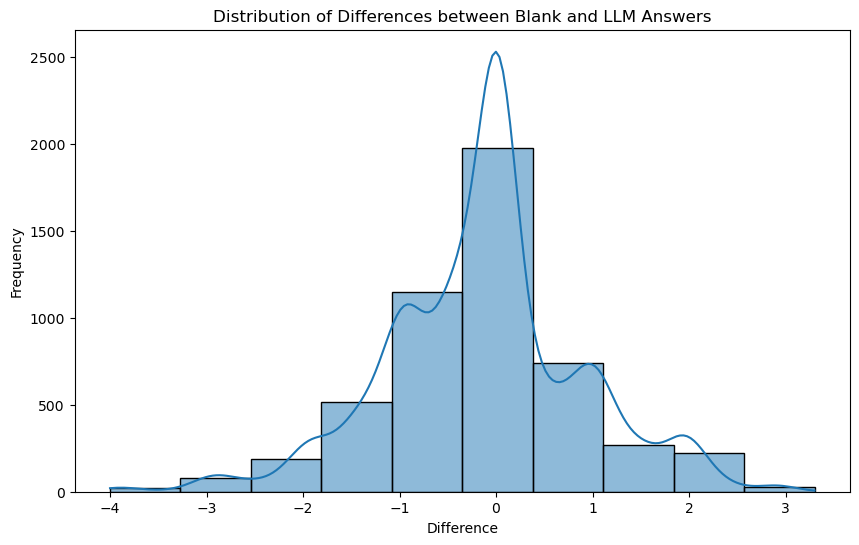

count    5184.000000
mean       -0.128164
std         1.028028
min        -4.000000
25%        -0.800000
50%        -0.100000
75%         0.300000
max         3.300000
Name: difference, dtype: float64


In [7]:
#hypothesis 1
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency

merged_data['difference'] = merged_data['RawAnswer'] - merged_data['PersonaAnswer']
plt.figure(figsize=(10, 6))
sns.histplot(merged_data['difference'], bins=10, kde=True)
plt.xlabel('Difference')
plt.ylabel('Frequency')
plt.title('Distribution of Differences between Blank and LLM Answers')
plt.show()

# Summary statistics
print(merged_data['difference'].describe())

In [8]:
# determine switches for hypothesis 3
for index, row in merged_data.iterrows():
    if round(row['difference']) != 0:
        if row["PartyPosition"] == "stimme zu": 
            position = [4,5]
        else:
            position = [1,2]
        if row['PersonaAnswer'] in position and round(row['RawAnswer']) not in position:
            merged_data.loc[index, 'switch'] = True
        else:
            merged_data.loc[index, 'switch'] = False
    else:
            merged_data.loc[index, 'switch'] = False


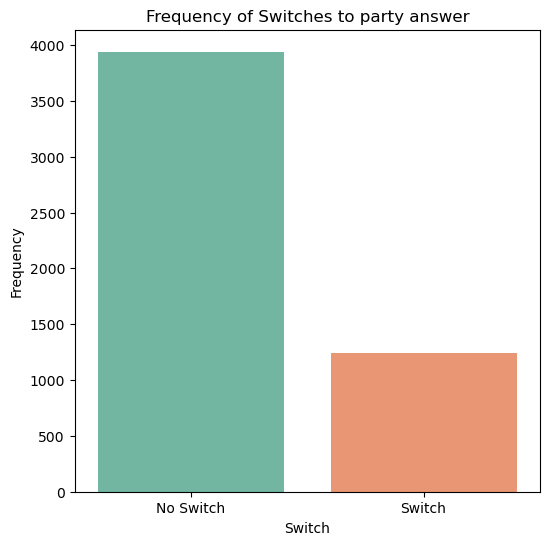

Percentage of switches: 24.00%
Percentage of no switches: 76.00%


In [9]:
#hypothesis 3
switch_counts = merged_data['switch'].value_counts()

# Visualize the frequency of switches
plt.figure(figsize=(6, 6))
sns.countplot(data=merged_data, x='switch', palette='Set2')
plt.xlabel('Switch')
plt.ylabel('Frequency')
plt.title('Frequency of Switches to party answer')
plt.xticks([0, 1], ['No Switch', 'Switch'])
plt.show()

# Calculate the percentage of switches
total_switches = switch_counts[True] if True in switch_counts else 0
total_no_switches = switch_counts[False] if False in switch_counts else 0
total_rows = len(merged_data)

percentage_switches = (total_switches / total_rows) * 100
percentage_no_switches = (total_no_switches / total_rows) * 100

print("Percentage of switches: {:.2f}%".format(percentage_switches))
print("Percentage of no switches: {:.2f}%".format(percentage_no_switches))

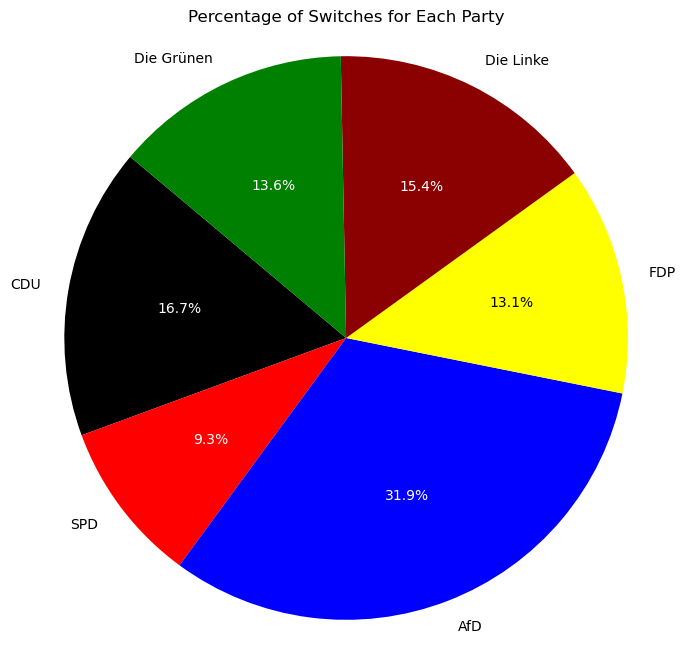

Percentage of switches for each party:
PartyId
1    24.074074
2    13.425926
3    45.949074
4    18.865741
5    22.106481
6    19.560185
dtype: float64


In [10]:
from matplotlib.colors import to_rgb

party_mapping = {
    1: {'name': 'CDU', 'color': 'black'},
    2: {'name': 'SPD', 'color': 'red'},
    3: {'name': 'AfD', 'color': 'blue'},
    4: {'name': 'FDP', 'color': 'yellow'},
    5: {'name': 'Die Linke', 'color': 'darkred'},
    6: {'name': 'Die Grünen', 'color': 'green'}
}
merged_data['PartyName'] = merged_data['PartyId'].map(lambda x: party_mapping[x]['name'])
merged_data['PartyColor'] = merged_data['PartyId'].map(lambda x: party_mapping[x]['color'])

# Group the data by PartyId and calculate the frequency of switches for each party
party_switch_counts = merged_data.groupby('PartyId')['switch'].value_counts().unstack(fill_value=0)

# Calculate the total number of responses for each party
party_total_counts = merged_data['PartyId'].value_counts()

# Calculate the percentage of switches for each party
party_switch_percentages = (party_switch_counts[True] / party_total_counts) * 100

def get_text_color(background_color):
    rgb = to_rgb(background_color)
    # Convert background color to grayscale
    grayscale = 0.2126 * rgb[0] + 0.7152 * rgb[1] + 0.0722 * rgb[2]
    # Determine text color based on grayscale value
    if grayscale > 0.5:
        return 'black'  # Use black text for light backgrounds
    else:
        return 'white'  # Use white text for dark backgrounds

background_colors = [party_mapping[i]['color'] for i in party_switch_percentages.index]
text_colors = [get_text_color(background_color) for background_color in background_colors]
# Visualize the percentage of switches for each party using a pie chart with colors
plt.figure(figsize=(8, 8))
patches, texts, autotexts = plt.pie(
    party_switch_percentages, 
    labels=party_switch_percentages.index.map(lambda x: party_mapping[x]['name']), 
    autopct='%1.1f%%', 
    startangle=140, 
    colors=background_colors
)

# Set text color dynamically based on background color
for autotext, background_color in zip(autotexts, background_colors):
    autotext.set_color(get_text_color(background_color))

plt.title('Percentage of Switches for Each Party')
plt.axis('equal')
plt.show()


# Display the percentage of switches for each party
print("Percentage of switches for each party:")
print(party_switch_percentages)


In [11]:
real_politicians_data = merged_data[merged_data['SourceId'] == 5]

other_personas_data = merged_data[merged_data['SourceId'].isin([1, 2, 3, 4])]

# Calculate the total number of responses for each group
total_responses_real_politicians = len(real_politicians_data)
total_responses_other_personas = len(other_personas_data)

# Calculate the number of switches for each group
switches_real_politicians = real_politicians_data['switch'].sum()
switches_other_personas = other_personas_data['switch'].sum()
print(len(real_politicians_data), switches_real_politicians)
print(len(other_personas_data) , switches_other_personas)
all_switches = switches_real_politicians + switches_other_personas
# Calculate the switch frequencies
real_politicians_switch_frequency = (switches_real_politicians / all_switches) * 100
other_personas_switch_frequency = (switches_other_personas / all_switches) * 100

# Compare the switch frequencies between the two groups
print("Switch frequency for PersonaAnswers based on real politicians (SourceId == 5): {:.2f}%".format(real_politicians_switch_frequency))
print("Switch frequency for other PersonaAnswers (SourceId 1-4): {:.2f}%".format(other_personas_switch_frequency))


2880 685
2304 559
Switch frequency for PersonaAnswers based on real politicians (SourceId == 5): 55.06%
Switch frequency for other PersonaAnswers (SourceId 1-4): 44.94%
